In [1]:
#Modified version of the following script from nilearn: 
#https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html
from nilearn import datasets
from tqdm.notebook import tqdm

development_dataset = datasets.fetch_development_fmri()

In [2]:
from nilearn import input_data

msdl_data = datasets.fetch_atlas_msdl()
masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1).fit()

/home/fleetwood/miniconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [3]:
children = []
pooled_subjects = []
groups = []  # child or adult
for func_file, confound_file, phenotypic in tqdm(zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic)):
    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    if phenotypic['Child_Adult'] == 'child':
        children.append(time_series)
    groups.append(phenotypic['Child_Adult'])

print('Data has {0} children.'.format(len(children)))

0it [00:00, ?it/s]

Data has 122 children.


In [4]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from nilearn.connectome import ConnectivityMeasure
import rust_dtw
import numpy as np

kinds = ['dtw', 'correlation', 'partial correlation', 'tangent']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects)

scores = {}
for kind in kinds:
    print('PROCESSING: ', kind)
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        if kind == 'dtw':
            connectomes = rust_dtw.dtw_connectomes(
                connectomes=pooled_subjects[train], 
                window=100, 
                vectorize=True, 
                distance_mode="euclidean"
            )
            test_connectomes = rust_dtw.dtw_connectomes(
                connectomes=pooled_subjects[test], 
                window=100, 
                vectorize=True, 
                distance_mode="euclidean"
            )
        else:
            connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
            connectomes = connectivity.fit_transform(pooled_subjects[train])
            test_connectomes = connectivity.transform(pooled_subjects[test])
            
        classifier = LinearSVC(max_iter=10000).fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(test_connectomes)
        
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

PROCESSING:  dtw
PROCESSING:  correlation
PROCESSING:  partial correlation
PROCESSING:  tangent


[(0.9466666666666668, 'dtw'), (0.9066666666666667, 'correlation'), (0.92, 'partial correlation'), (0.9600000000000001, 'tangent')]


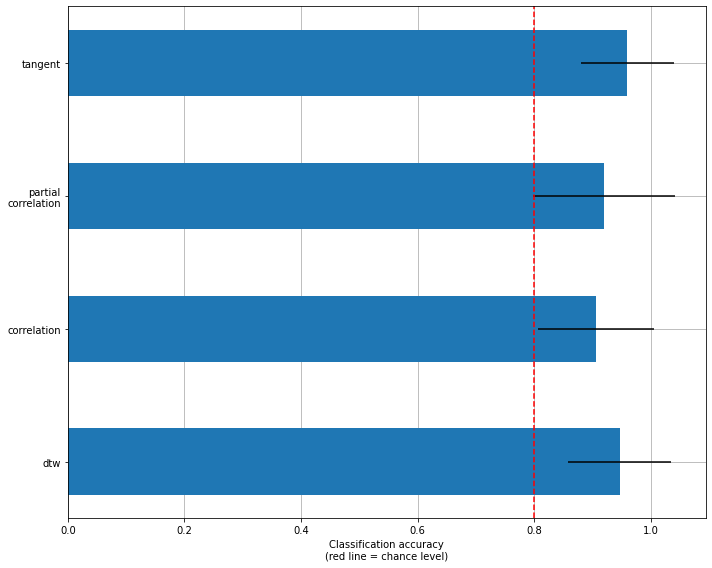

In [5]:
import matplotlib.pyplot as plt
mean_scores = [np.mean(scores[kind]) for kind in kinds]
print(list(zip(mean_scores, kinds) ))
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(10, 8))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.8, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()